In [50]:
%load_ext jupyternotify

import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import TSPN
import PollingSystem as PS
import MarkovianRP as MRP
import StaticRP as SRP
import dtr
import motion
import shot_solvers as SHOT

import sim_template as sim
from importlib import reload 

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [4]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


[15.5, 47.0] [34.5, 47.0]
[1.1974411167423504, 27.772758664047835] [10.697441116742354, 44.227241335952165]
[10.697441116742345, 5.772758664047837] [1.1974411167423495, 22.227241335952172]
[34.5, 2.9999999999999982] [15.499999999999996, 3.0000000000000004]
[48.802558883257646, 22.227241335952154] [39.30255888325764, 5.772758664047824]
[39.302558883257646, 44.227241335952165] [48.802558883257646, 27.772758664047835]
0.0625
[2.4, 2.4, 2.4, 2.4, 2.4, 2.4]


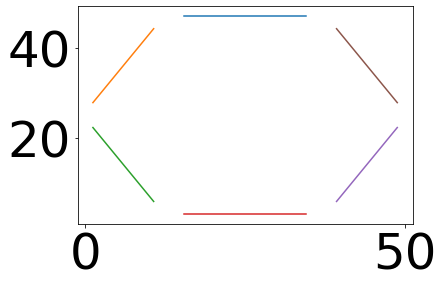

In [5]:
#Setup the communication environment:

#For now, use same channel params
nPL = 5.2
kPL = -20

decorrSH = 2.09  
alpha = 16
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5


#12 remote stations
rad = 22
le=19
center = [25, 25]
def gen_bs(c, r, l,  theta):
    #rotate 90 degrees
    field_center = [-r*np.sin(theta)+c[0], r*np.cos(theta)+c[1]]
    bs1 = [-1*(l/2)*np.sin(-(theta-np.pi/2))+field_center[0], (l/2)*np.cos(-(theta+np.pi/2))+field_center[1]]
    bs2 = [-1*(l/2)*np.sin(-(theta+np.pi/2))+field_center[0], (l/2)*np.cos(-(theta-np.pi/2))+field_center[1]]
    return bs1, bs2

qBase = []
for i in range(6):
    theta = i*2*np.pi/6
    b1, b2 = gen_bs(center, rad, le, theta)
    print(b1, b2)
    qBase.append(b1)
    qBase.append(b2)
    plt.plot([b1[0], b2[0]],[b1[1], b2[1]])
qBase = np.array(qBase)

sub_regions = [[40,10, 50,40],
               [16,0, 50, 22],
               [16,0, 28, 0],
               [40, 10, 10,0],
               [50, 34, 28, 0],
               [50, 34, 50, 22]]


x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]


cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]



#res = 2/decorrMP
res = 10
n = 6
p_th = 0.5

#Polling System Setup
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
print(beta)
els = [0.15/beta, 0.15/beta, 0.15/beta, 0.15/beta, 0.15/beta, 0.15/beta]
print(els)

In [6]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing genera

In [7]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs

print(prob_pred_con)

Drawing 300 samples from Channel 1
Completed PredictedChannel 1
Drawing 300 samples from Channel 2
Completed PredictedChannel 2
Drawing 448 samples from Channel 3
Completed PredictedChannel 3
Drawing 448 samples from Channel 4
Completed PredictedChannel 4
Drawing 448 samples from Channel 5
Completed PredictedChannel 5
Drawing 448 samples from Channel 6
Completed PredictedChannel 6
Drawing 300 samples from Channel 7
Completed PredictedChannel 7
Drawing 300 samples from Channel 8
Completed PredictedChannel 8
Drawing 448 samples from Channel 9
Completed PredictedChannel 9
Drawing 448 samples from Channel 10
Completed PredictedChannel 10
Drawing 448 samples from Channel 11
Completed PredictedChannel 11
Drawing 448 samples from Channel 12
Completed PredictedChannel 12
[0.7522236340533672, 0.7714285714285715, 0.71484375, 0.8338499690018599, 0.752542372881356, 0.856544502617801]


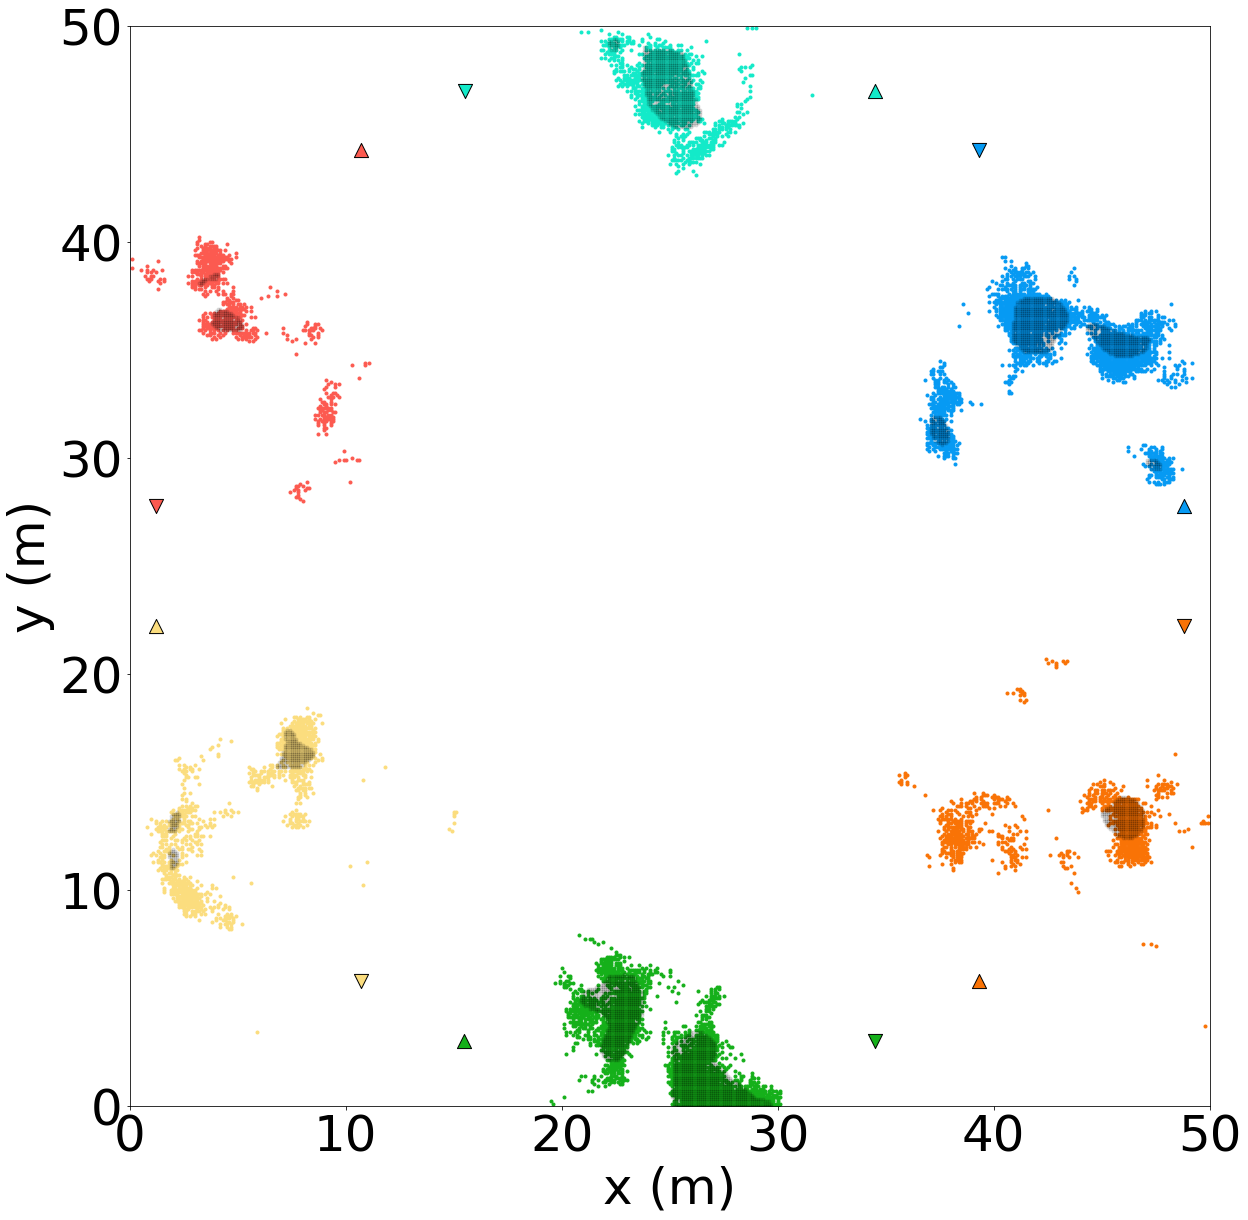

In [8]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [27]:
#setup the delay-tolerant relay system
reload(dtr)
dt_sys = dtr.DTR(pcs, region, els, beta, th=GAMMA_TH, p_th = p_th)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
6 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
4 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
7 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
10 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
2 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
9 total subregions


Total of 60 Permutations to Try
Working on Permutation (0, 1, 2, 3, 4, 5)
Optimal Solution Improved to 120.74
Working on Permutation (0, 1, 2, 3, 5, 4)
skiping based on lower bound
Working on Permutation (0, 1, 2, 4, 3, 5)
skiping based on lower bound
Working on Permutation (0, 1, 2, 4, 5, 3)
skiping based on lower bound
Working on Permutation (0, 1, 2, 5, 3, 4)
skiping based on lower bound
Working on Permutation (0, 1, 2, 5, 4, 3)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 4, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 5, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 2, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 5, 2)
skiping based on lower bound
Working on Permutation (0, 1, 3, 5, 2, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 5, 4, 2)
skiping based on lower bound
Working on Permutation (0, 1, 4, 2, 3, 5)
skiping based on lower bound
Working on Permutation (0, 1, 4, 2, 5,

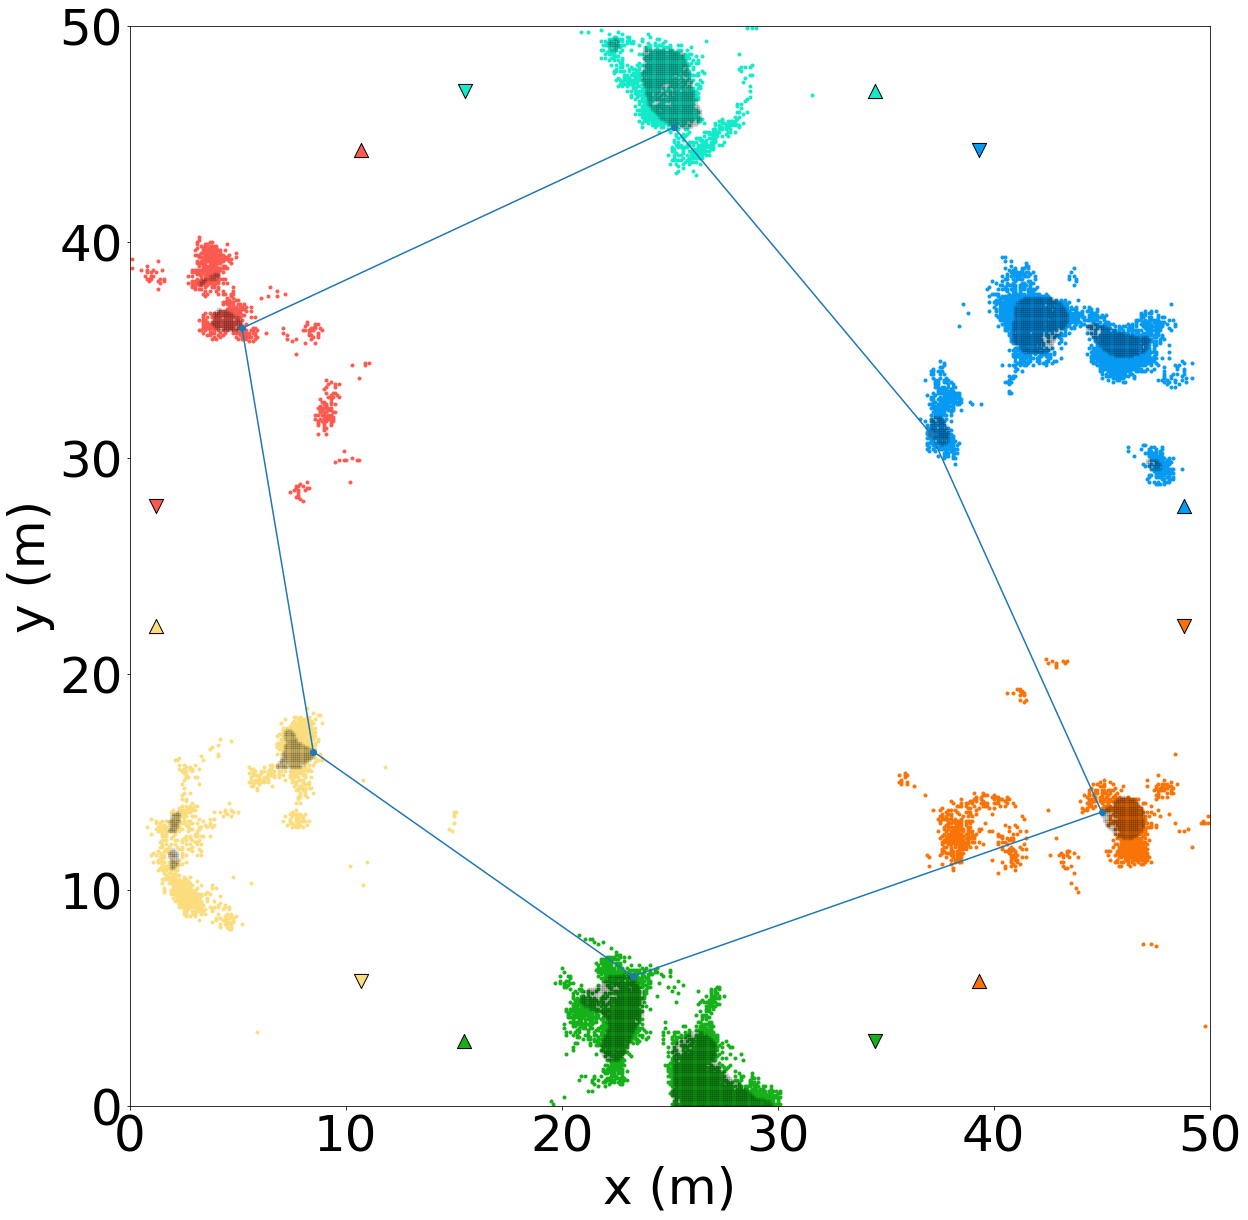

In [28]:
reload(sim)
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

TSPNP={'X':x, 'SEQ':tspn_argmin[1]}

order = list(tspn_argmin[1])
order.append(0)#complete the loop
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.plot(x[order,0], x[order,1], zorder=100)
plt.scatter(x[:,0], x[:,1], zorder = 100)
plt.gca().invert_yaxis()
plt.show()

In [47]:
def gen_dist():
    #generate by succesive division
    s1 = np.random.uniform(0.05,0.95)
    s2 = np.random.uniform(0.05,0.95)
    L = min(s1, s2)
    R = max(s1, s2)
    s3 = np.random.uniform(0.01, L-0.01)
    s4 = np.random.uniform(L+0.01, R-0.01)
    s5 = np.random.uniform(R+0.01, 0.99)
    return np.array([s3, L-s3, s4-L, R-s4, s5-R, 1-s5])


np.sum(np.array([gen_dist() for i in range(50)]), axis=1)


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [52]:
#symmetric geometry, asymmetric arrivals
n_trials = 50
#generate 50 different distributions over system traffic
v = 1
    
all_dists = np.array([gen_dist() for i in range(n_trials)])

sys_traffics = [0.2, 0.5, 0.8]

S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]

ps = dt_sys.ps
W_tab = np.zeros((3, n_trials))
W_tspnp = np.zeros((3, n_trials))
for i in range(3):
    sys_traffic = sys_traffics[i]
    for j in range(n_trials):
        print("Working on iteration (%d, %d)"%(i,j))
        #calc AORP
        ps.Ls = all_dists[j]*sys_traffic/beta
        AORP = sim.calc_AORP(dt_sys, v)
        pi = AORP['pi']
        S = dtr.XtoS(AORP['X'])
        #build table
        rtable = SRP.SRPFromPis(pi, eps=0.01)
        seconds = 2*60*60
        xt, wt, queues, total_travel_time, _, _, _ = ps.simulate(rtable, S, seconds)
        print(wt[-1][1])
        W_tab[i,j] = wt[-1][1]
        W_tspnp[i,j] = ps._calc_avg_wait_cyclic(S_cyv)


Working on iteration (0, 0)
69.87741158196052
Working on iteration (0, 1)
93.2722998403991
Working on iteration (0, 2)
100.98454403844079
Working on iteration (0, 3)
114.4370457636365
Working on iteration (0, 4)
122.43975521243756
Working on iteration (0, 5)
115.337591712661
Working on iteration (0, 6)
72.02473939023538
Working on iteration (0, 7)
123.77987803114073
Working on iteration (0, 8)
108.945289255925
Working on iteration (0, 9)
79.56050113038111
Working on iteration (0, 10)
128.2923511759082
Working on iteration (0, 11)
120.31056588545357
Working on iteration (0, 12)
86.09049398269546
Working on iteration (0, 13)
111.12707039421505
Working on iteration (0, 14)
94.7950857491444
Working on iteration (0, 15)
109.23099416459272
Working on iteration (0, 16)
89.7533914141099
Working on iteration (0, 17)
95.91887031545049
Working on iteration (0, 18)
123.10902015888009
Working on iteration (0, 19)
83.56848304280109
Working on iteration (0, 20)
101.11131707598244
Working on iteration

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


84.06816881077556
Working on iteration (0, 30)
103.13854093937132
Working on iteration (0, 31)
93.91427097078655
Working on iteration (0, 32)
112.883772947679
Working on iteration (0, 33)
108.907738211002
Working on iteration (0, 34)
88.07550632035039
Working on iteration (0, 35)
104.12368759681863
Working on iteration (0, 36)
58.95482318804415
Working on iteration (0, 37)


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


68.02024954051159
Working on iteration (0, 38)
111.36315460561316
Working on iteration (0, 39)
90.05491265693438
Working on iteration (0, 40)
101.52631499710428
Working on iteration (0, 41)
119.75203277789075
Working on iteration (0, 42)
103.98553704757539
Working on iteration (0, 43)
121.90860615456978
Working on iteration (0, 44)
116.87130713610803
Working on iteration (0, 45)


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


53.11484258084731
Working on iteration (0, 46)
72.21015616163777
Working on iteration (0, 47)
102.69470209846212
Working on iteration (0, 48)


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


58.8178444524833
Working on iteration (0, 49)
107.68967648099594
Working on iteration (1, 0)
100.30084420948914
Working on iteration (1, 1)
130.70648962133473
Working on iteration (1, 2)
149.37701740774853
Working on iteration (1, 3)
168.8110576771259
Working on iteration (1, 4)
178.90935856075643
Working on iteration (1, 5)
167.8456769129076
Working on iteration (1, 6)
106.95625150075891
Working on iteration (1, 7)
183.41132105374672
Working on iteration (1, 8)
160.6228112045456
Working on iteration (1, 9)
117.3089656252228
Working on iteration (1, 10)
191.87489436456352
Working on iteration (1, 11)
177.42103495039578
Working on iteration (1, 12)
122.37772797326923
Working on iteration (1, 13)
165.1473909438043
Working on iteration (1, 14)
140.76258550984159
Working on iteration (1, 15)
156.97498052365194
Working on iteration (1, 16)
127.248183898929
Working on iteration (1, 17)
140.13281435493715
Working on iteration (1, 18)
183.35944629266552
Working on iteration (1, 19)
122.8257524

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


120.54983885193498
Working on iteration (1, 30)
147.7676825191135
Working on iteration (1, 31)
136.30261796348896
Working on iteration (1, 32)
164.75326903570573
Working on iteration (1, 33)
161.01419305050862
Working on iteration (1, 34)
129.14290987824674
Working on iteration (1, 35)
154.8522486521155
Working on iteration (1, 36)


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


85.01138607881836
Working on iteration (1, 37)
96.42106507375526
Working on iteration (1, 38)
162.14037370568937
Working on iteration (1, 39)
129.99261984556455
Working on iteration (1, 40)
149.32344708306604
Working on iteration (1, 41)
175.3072226867832
Working on iteration (1, 42)
154.53637997278835
Working on iteration (1, 43)
176.95405565713335
Working on iteration (1, 44)
173.3155965313096
Working on iteration (1, 45)


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


76.0999755183959
Working on iteration (1, 46)
97.95028131974543
Working on iteration (1, 47)
146.9197791860367
Working on iteration (1, 48)


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


61.55817971990057
Working on iteration (1, 49)
159.76258457042692
Working on iteration (2, 0)
198.79037360654786
Working on iteration (2, 1)
261.2335794080308
Working on iteration (2, 2)
301.6699153588454
Working on iteration (2, 3)
352.1094653188133
Working on iteration (2, 4)
361.0923002276039
Working on iteration (2, 5)
348.93609985191785
Working on iteration (2, 6)
207.90837851313125
Working on iteration (2, 7)
357.04500155738236
Working on iteration (2, 8)
337.3657086914223
Working on iteration (2, 9)
237.4267920126431
Working on iteration (2, 10)
391.9593657801039
Working on iteration (2, 11)
362.4209045174984
Working on iteration (2, 12)
244.02522723623198
Working on iteration (2, 13)
344.5040391752379
Working on iteration (2, 14)
290.80178138182924
Working on iteration (2, 15)
325.68107568049425
Working on iteration (2, 16)
250.2577249295874
Working on iteration (2, 17)
296.45447702506544
Working on iteration (2, 18)
360.9022932744853
Working on iteration (2, 19)
243.9267076115

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


145.6326425787857
Working on iteration (2, 46)
178.8313601306181
Working on iteration (2, 47)
313.7458127176591
Working on iteration (2, 48)


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


107.09196651803477
Working on iteration (2, 49)
307.46319123911735


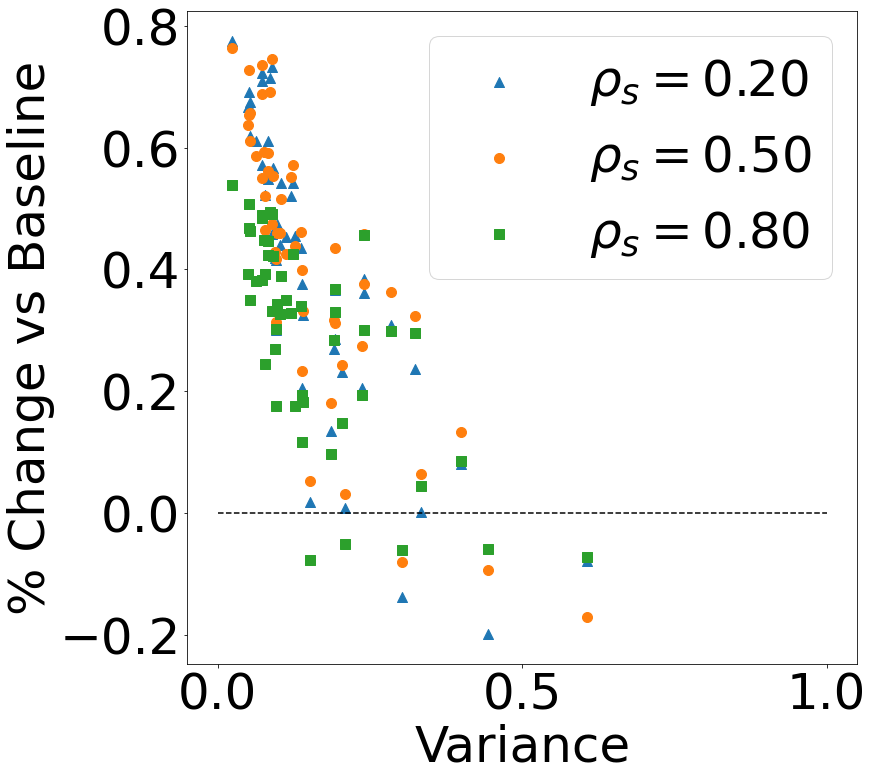

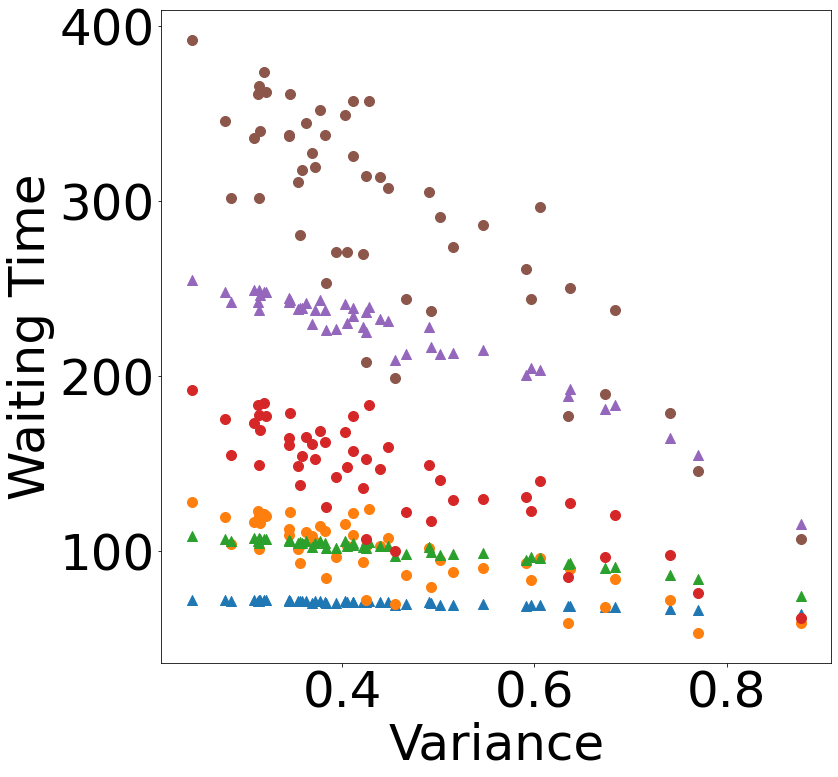

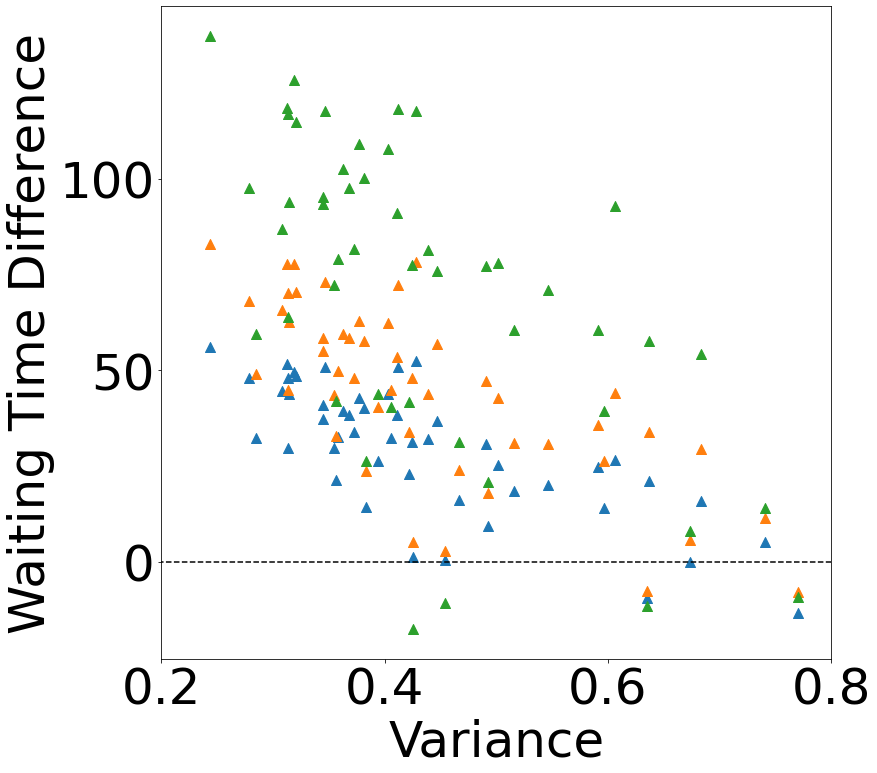

In [105]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 50})
variance = np.var(all_dists, axis=1)*6#normalize
max_rho = np.max(all_dists, axis=1)
fig = plt.figure(figsize=(12,12))
markers = ["^", "o", "s"]
for i in range(3):
    #plt.scatter(max_rho, W_tspnp[i,:], marker="^", s=100, label="")#, color=sim.COLORS[i+3])
    # linear fit is not a good fit
#     z = np.polyfit(variance, W_tspnp[i,:],1)
#     p = np.poly1d(z)
#     plt.plot(variance, p(variance))
    #plt.scatter(max_rho, W_tab[i,:], marker="o", s=100)#, color=sim.COLORS[i+3])
    plt.scatter(variance, (W_tab[i,:]-W_tspnp[i,:])/W_tspnp[i,:], marker=markers[i], s=100,
                label="$\\rho_s=%.2f$"%(sys_traffics[i]))
#     z = np.polyfit(max_rho,  W_tab[i,:]-W_tspnp[i,:],1)
#     p = np.poly1d(z)
#     plt.plot(max_rho, p(max_rho), '-k')
    
plt.plot([0, 1], [0,0], "--k")
#plt.xlim(0.2,0.8)
# plt.ylim(-10, 100)
plt.xlabel("Variance")
plt.ylabel("% Change vs Baseline")
plt.legend()
plt.show()

fig = plt.figure(figsize=(12,12))
for i in range(3):
    plt.scatter(max_rho, W_tspnp[i,:], marker="^", s=100, label="")#, color=sim.COLORS[i+3])
    # linear fit is not a good fit
#     z = np.polyfit(variance, W_tspnp[i,:],1)
#     p = np.poly1d(z)
#     plt.plot(variance, p(variance))
    plt.scatter(max_rho, W_tab[i,:], marker="o", s=100)#, color=sim.COLORS[i+3])
#     plt.scatter(variance, (W_tab[i,:]-W_tspnp[i,:])/W_tspnp[i,:], marker=markers[i], s=100,
#                 label="$\\rho_s=%.2f$"%(sys_traffics[i]))
#     z = np.polyfit(max_rho,  W_tab[i,:]-W_tspnp[i,:],1)
#     p = np.poly1d(z)
#     plt.plot(max_rho, p(max_rho), '-k')
    
plt.xlabel("Variance")
plt.ylabel("Waiting Time")
plt.show()

fig = plt.figure(figsize=(12,12))
for i in range(3):
    plt.scatter(max_rho,  W_tab[i,:]- W_tspnp[i,:], marker="^", s=100, label="")#, color=sim.COLORS[i+3])
plt.plot([0, 1], [0,0], "--k")
plt.xlim(0.2,0.8)
# plt.ylim(-10, 100)
plt.xlabel("Variance")
plt.ylabel("Waiting Time Difference")
plt.show()

In [92]:
1/6

0.16666666666666666